# EA1:

*By Daniel Deutsch and José Lucas Barretto*

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

In [32]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

## Load and process the dataset

We chose to work with NASDAQ's Composite Index series for the homework. Let's start by loading, processing, and visualizing the index's values and log-values.

In [36]:
# load and process dataset
df = pd.read_csv("datasets/NASDAQ_Index.csv", parse_dates=[0], dtype={1: np.float64}, na_values='.')
df.rename(columns={'DATE': 'date', 'NASDAQCOM': 'value'}, inplace=True)

# apply log to values
df['log_value'] = np.log(df['value'])

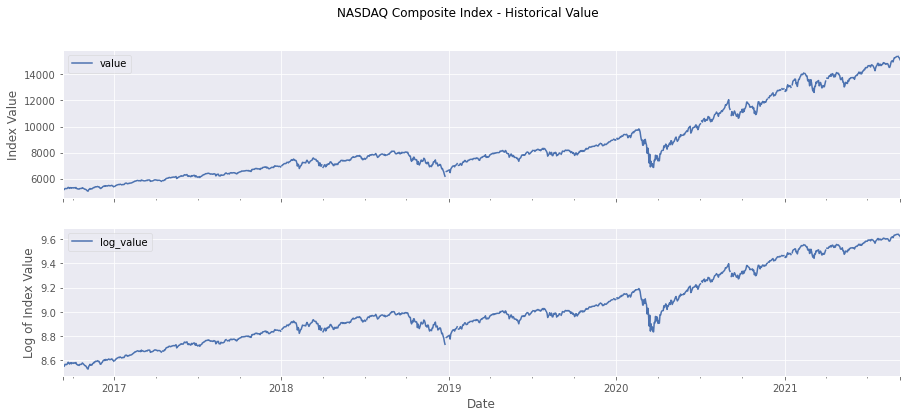

In [40]:
# plot series' values and log-values
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))

df.plot(x='date', y='value', ax=ax[0])
ax[0].set_ylabel("Index Value")

df.plot(x='date', y='log_value', ax=ax[1])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log of Index Value")

fig.suptitle("NASDAQ Composite Index - Historical Value")
plt.show()

We can see that the data has a daily frequency, and ranges from september 2016 to september 2021. We will now divide the series into two different periods. The first period ranges from september 2016 up to the start of 2019, where the series shows a relatively controlled growing behavior. The second period, which ranges from the start of 2019 until september 2021, on the other hand, contains extremely volatile periods. This will allow us to study the unpredictable behavior of stock markets, by analysing two very different behaviors of the same asset.

In [51]:
mask = df['date'] < '2019-01-01'
series1 = df[mask]
series2 = df[~mask]

## Examine whether the series are martingales or not.

We will test the hypothesis:

$$H_0:\text{The series is a martingale process.}$$

If the hypothesis is true, then:

$$ \mathbf{E}[P_{t+1}|P_t, P_{t-1}, ..., P_0] = P_t \Leftrightarrow P_{t+1} = P_t + \epsilon_{t+1}$$

Where $$\mathbf{E}[\epsilon_{t+1} | P_t, P_{t-1}, ..., P_0] = 0 $$

In [56]:
tsa.AutoReg()

TypeError: __init__() missing 2 required positional arguments: 'endog' and 'lags'